In [109]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from scipy.stats import dirichlet
from evml.keras.models import CategoricalDNN
import yaml
from bridgescaler import load_scaler

%matplotlib inline

In [47]:
fn_config = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/evidential_unweighted/model.yml"
with open(fn_config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
input_features = (
    conf["TEMP_C"] + conf["T_DEWPOINT_C"] + conf["UGRD_m/s"] + conf["VGRD_m/s"]
)
output_features = conf["ptypes"]


In [164]:
output_features

['ra_percent', 'sn_percent', 'pl_percent', 'fzra_percent']

In [48]:
model = CategoricalDNN.load_model(conf)

2023-08-21 11:25:37.023645: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [51]:
test_data = pd.read_parquet("/glade/p/cisl/aiml/ai2es/winter_ptypes/models/evidential_unweighted/evaluate/test_19.parquet")

In [54]:
input_scaler_loc = os.path.join(conf["save_loc"], "scalers", "input.json")

input_scaler = load_scaler(input_scaler_loc)

In [55]:
scaled_input_x = input_scaler.transform(test_data[input_features])

In [60]:
test_preds = model.model.predict(scaled_input_x, batch_size=1000)

397/397 [==============================] - 1s 3ms/step


In [61]:
test_preds[:, 2].argmax()

317229

In [238]:
test_preds[:, 2].argsort()[-1:-10:-1]

array([317229, 317359, 317524, 317671, 317529, 317537, 317360, 317375,
       317856])

In [291]:
ps = np.arange(0, 1.01, 0.01)
all_ps = np.meshgrid(ps, 1-ps)
p_db = np.vstack([all_p.ravel() for all_p in all_ps]).T
p_simp = p_db[p_db.sum(axis=1)==1]

In [295]:
all_ps

[array([[0.  , 0.01, 0.02, ..., 0.98, 0.99, 1.  ],
        [0.  , 0.01, 0.02, ..., 0.98, 0.99, 1.  ],
        [0.  , 0.01, 0.02, ..., 0.98, 0.99, 1.  ],
        ...,
        [0.  , 0.01, 0.02, ..., 0.98, 0.99, 1.  ],
        [0.  , 0.01, 0.02, ..., 0.98, 0.99, 1.  ],
        [0.  , 0.01, 0.02, ..., 0.98, 0.99, 1.  ]]),
 array([[1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
        [0.99, 0.99, 0.99, ..., 0.99, 0.99, 0.99],
        [0.98, 0.98, 0.98, ..., 0.98, 0.98, 0.98],
        ...,
        [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
        [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])]

In [115]:
heights = np.arange(0, 5250.0, 250)
temps = np.linspace(0, -20, heights.size)
dewps = np.linspace(-10, -30, heights.size)
us = np.linspace(-10, 30, heights.size)
vs = np.linspace(-5, 10, heights.size)
px = np.arange(0, 1, 0.01)
pall = np.concatenate([px, 1-px]).reshape(2, px.size)
dp = dirichlet.pdf(pall, [10, 3])

In [306]:
idx = 317529
temps = test_data.iloc[idx][conf["TEMP_C"]]
dewps = test_data.iloc[idx][conf["T_DEWPOINT_C"]]
us = test_data.iloc[idx][conf["UGRD_m/s"]]
vs = test_data.iloc[idx][conf["VGRD_m/s"]]
heights = np.arange(0, 5250.0, 250)
test_ev = np.maximum(test_preds[idx], 0)
test_alpha = test_ev + 1
dp = dirichlet.pdf(p_simp.T, test_alpha[2:])
dp_ens = dirichlet.rvs(test_alpha[2:], size=20)
test_belief = np.concatenate([test_ev / test_alpha.sum(), [test_ev.shape[0] / test_alpha.sum()]])

In [277]:
s = test_alpha.sum()
evi_epi = (test_alpha[2] / s * (1 - test_alpha[2] / s)) / (s + 1)
evi_ale = test_alpha[2] / s - (test_alpha[2] / s) ** 2 - evi_epi
ens_epi = np.var(dp_ens[:, 0])
ens_ale = np.mean(dp_ens[:, 0] * (1 - dp_ens[:, 0]))

In [273]:
test_alpha

array([ 1.       ,  1.       , 13.731872 ,  2.9111688], dtype=float32)

In [278]:
total_evi_epi = 0
s = test_alpha.sum()
for i in range(4):
    total_evi_epi += (test_alpha[i] / s * (1 - test_alpha[i] / s)) / (s + 1)
print(np.sqrt(total_evi_epi))

0.14423118590624248


In [279]:
print(np.sqrt(evi_epi), np.sqrt(evi_ale))
print(np.sqrt(ens_epi), np.sqrt(ens_ale))

0.0973584756519364 0.4245151691664927
0.07902371068892036 0.36462115701802744


In [256]:
evi_epi

0.009478672781268693

In [255]:
test_belief

array([0.        , 0.        , 0.69298029, 0.09663168, 0.21038806])

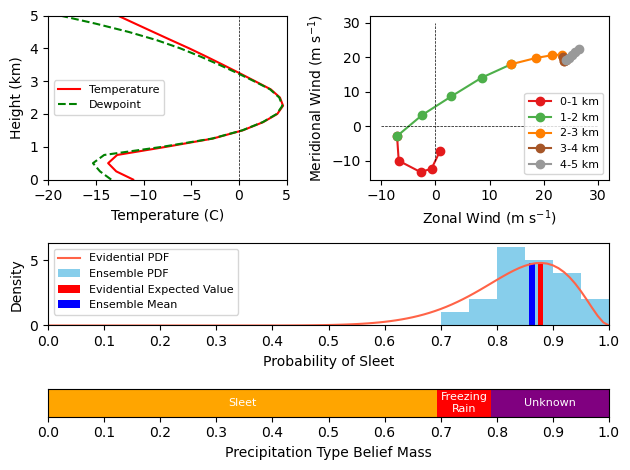

In [309]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(3, 2, height_ratios=[0.6, 0.3, 0.1])
ax = fig.add_subplot(gs[0,0])
ax.plot(temps, heights / 1000, color='r', label="Temperature")
ax.plot(dewps, heights / 1000, color='g', label="Dewpoint", linestyle='--')
ax.set_xticks(np.arange(-20, 10, 5))
ax.set_xlim(-20, 5)
ax.legend(fontsize=8)
ax.set_xlabel("Temperature (C)")
ax.set_ylabel("Height (km)")
ax.plot(np.zeros(heights.shape[0]), heights / 1000, 'k--', lw=0.5)
ax.set_ylim(0, 5)
ax = fig.add_subplot(gs[0, 1])
cmap = plt.get_cmap("Set1", 5)
levels = ["0-1 km", "1-2 km", "2-3 km", "3-4 km", "4-5 km"]
hodo_ticks = np.arange(-10, 40, 10)
for i in range(5):
    ax.plot(us[4 * i: 4 * i +5], vs[4* i:4 * i + 5], marker='o', color=cmap.colors[i], label=levels[i])
ax.plot(np.zeros(hodo_ticks.shape), hodo_ticks, 'k--', lw=0.5)
ax.plot(hodo_ticks, np.zeros(hodo_ticks.shape),  'k--', lw=0.5)

ax.set_xlabel("Zonal Wind (m s$^{-1}$)")
ax.set_ylabel("Meridional Wind (m s$^{-1}$)")
ax.set_xticks(hodo_ticks)
ax.set_yticks(hodo_ticks)
ax.legend(fontsize=8)

ax = fig.add_subplot(gs[1, :])
#ax.bar([0, 1], test_ev[2:][::-1], 0.02)
ax.plot(p_simp[:, 0],dp, color='tomato', label="Evidential PDF")
ax.hist(dp_ens[:, 0], np.arange(0, 1.05, .05), density=True, color='skyblue', label="Ensemble PDF")
ax.bar([test_ev[2]/test_ev.sum()], [dp.max()], 0.01, color='r', label="Evidential Expected Value")
ax.bar([dp_ens[:, 0].mean()], [dp.max()], 0.01, color='b', label="Ensemble Mean")
ax.legend(fontsize=8)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim(0, 1)
ax.set_xlabel("Probability of Sleet")
ax.set_ylabel("Density")
ax = fig.add_subplot(gs[2, :])
#ax.bar([0, 1], test_ev[2:][::-1], 0.02)
p_type_colors = ["green", "blue", "orange", "red", "purple"]
p_type_labels = ["Rain", "Snow", "Sleet", "Freezing\nRain", "Unknown"]
for b in range(test_belief.shape[0]):
    if b == 0:
        ax.barh(0.5, test_belief[b], height=1, left=0, color=p_type_colors[b])
    else:
        ax.barh(0.5, test_belief[b], height=1, left=test_belief.cumsum()[b-1], color=p_type_colors[b])
    if test_belief[b] > 0:
        if b == 0:
            ax.text((0 + test_belief.cumsum()[b]) / 2, 0.5, p_type_labels[b], 
                    ha="center", va="center", fontsize=8, color='white')
        else:
            ax.text((test_belief.cumsum()[b-1] + test_belief.cumsum()[b]) / 2, 0.5, p_type_labels[b], 
                    ha="center", va="center", fontsize=8, color='white')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Precipitation Type Belief Mass")
plt.savefig("evidential_figure_1.png", dpi=300, bbox_inches="tight")
plt.savefig("evidential_figure_1.pdf", bbox_inches="tight")

In [302]:
idx = 317529
temps = test_data.iloc[idx][conf["TEMP_C"]]
dewps = test_data.iloc[idx][conf["T_DEWPOINT_C"]]
us = test_data.iloc[idx][conf["UGRD_m/s"]]
vs = test_data.iloc[idx][conf["VGRD_m/s"]]
heights = np.arange(0, 5250.0, 250)
test_ev = np.maximum(test_preds[idx], 0)
test_alpha = test_ev + 1
dst_u = test_ev.shape[0] / test_alpha.sum()
dp = dirichlet.pdf(p_simp.T, test_alpha[2:])
dp_ens = dirichlet.rvs(test_alpha[2:], size=20) * (1-dst_u)
test_belief = np.concatenate([test_ev / test_alpha.sum(), [dst_u]])

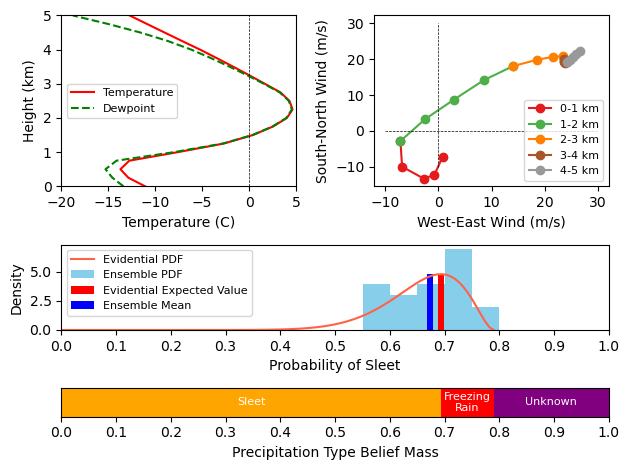

In [305]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(3, 2, height_ratios=[0.6, 0.3, 0.1])
ax = fig.add_subplot(gs[0,0])
ax.plot(temps, heights / 1000, color='r', label="Temperature")
ax.plot(dewps, heights / 1000, color='g', label="Dewpoint", linestyle='--')
ax.set_xticks(np.arange(-20, 10, 5))
ax.set_xlim(-20, 5)
ax.legend(fontsize=8)
ax.set_xlabel("Temperature (C)")
ax.set_ylabel("Height (km)")
ax.plot(np.zeros(heights.shape[0]), heights / 1000, 'k--', lw=0.5)
ax.set_ylim(0, 5)
ax = fig.add_subplot(gs[0, 1])
cmap = plt.get_cmap("Set1", 5)
levels = ["0-1 km", "1-2 km", "2-3 km", "3-4 km", "4-5 km"]
hodo_ticks = np.arange(-10, 40, 10)
for i in range(5):
    ax.plot(us[4 * i: 4 * i +5], vs[4* i:4 * i + 5], marker='o', color=cmap.colors[i], label=levels[i])
ax.plot(np.zeros(hodo_ticks.shape), hodo_ticks, 'k--', lw=0.5)
ax.plot(hodo_ticks, np.zeros(hodo_ticks.shape),  'k--', lw=0.5)

ax.set_xlabel("West-East Wind (m/s)")
ax.set_ylabel("South-North Wind (m/s)")
ax.set_xticks(hodo_ticks)
ax.set_yticks(hodo_ticks)
ax.legend(fontsize=8)

ax = fig.add_subplot(gs[1, :])
#ax.bar([0, 1], test_ev[2:][::-1], 0.02)
ax.plot(p_simp[:, 0] * (1-dst_u),dp, color='tomato', label="Evidential PDF")
ax.hist(dp_ens[:, 0], np.arange(0, 1.05, .05), density=True, color='skyblue', label="Ensemble PDF")
ax.bar([test_ev[2]/test_ev.sum() * (1-dst_u)], [dp.max()], 0.01, color='r', label="Evidential Expected Value")
ax.bar([dp_ens[:, 0].mean()], [dp.max()], 0.01, color='b', label="Ensemble Mean")
ax.legend(fontsize=8)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim(0, 1)
ax.set_xlabel("Probability of Sleet")
ax.set_ylabel("Density")

ax = fig.add_subplot(gs[2, :])
#ax.bar([0, 1], test_ev[2:][::-1], 0.02)
p_type_colors = ["green", "blue", "orange", "red", "purple"]
p_type_labels = ["Rain", "Snow", "Sleet", "Freezing\nRain", "Unknown"]
for b in range(test_belief.shape[0]):
    if b == 0:
        ax.barh(0.5, test_belief[b], height=1, left=0, color=p_type_colors[b])
    else:
        ax.barh(0.5, test_belief[b], height=1, left=test_belief.cumsum()[b-1], color=p_type_colors[b])
    if test_belief[b] > 0:
        if b == 0:
            ax.text((0 + test_belief.cumsum()[b]) / 2, 0.5, p_type_labels[b], 
                    ha="center", va="center", fontsize=8, color='white')
        else:
            ax.text((test_belief.cumsum()[b-1] + test_belief.cumsum()[b]) / 2, 0.5, p_type_labels[b], 
                    ha="center", va="center", fontsize=8, color='white')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Precipitation Type Belief Mass")
plt.savefig("evidential_figure_1_bel.png", dpi=300, bbox_inches="tight")
plt.savefig("evidential_figure_1_bel.pdf", bbox_inches="tight")

In [133]:
test_ev[2]/test_ev.sum()

0.8972387

In [150]:
p_simp

array([[1.  , 0.  ],
       [0.99, 0.01],
       [0.98, 0.02],
       [0.97, 0.03],
       [0.96, 0.04],
       [0.95, 0.05],
       [0.94, 0.06],
       [0.93, 0.07],
       [0.92, 0.08],
       [0.91, 0.09],
       [0.9 , 0.1 ],
       [0.89, 0.11],
       [0.88, 0.12],
       [0.87, 0.13],
       [0.86, 0.14],
       [0.85, 0.15],
       [0.84, 0.16],
       [0.83, 0.17],
       [0.82, 0.18],
       [0.81, 0.19],
       [0.8 , 0.2 ],
       [0.79, 0.21],
       [0.78, 0.22],
       [0.77, 0.23],
       [0.76, 0.24],
       [0.75, 0.25],
       [0.74, 0.26],
       [0.73, 0.27],
       [0.72, 0.28],
       [0.71, 0.29],
       [0.7 , 0.3 ],
       [0.69, 0.31],
       [0.68, 0.32],
       [0.67, 0.33],
       [0.66, 0.34],
       [0.65, 0.35],
       [0.64, 0.36],
       [0.63, 0.37],
       [0.62, 0.38],
       [0.61, 0.39],
       [0.6 , 0.4 ],
       [0.59, 0.41],
       [0.58, 0.42],
       [0.57, 0.43],
       [0.56, 0.44],
       [0.55, 0.45],
       [0.54, 0.46],
       [0.53,

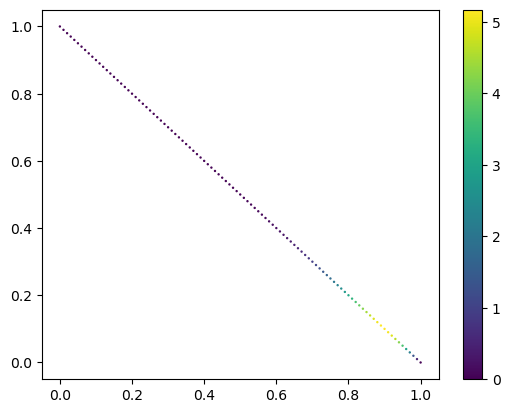

In [149]:
plt.scatter(p_simp[:, 0], p_simp[:, 1], 0.5, dp)
plt.colorbar()

In [123]:
p_simp

array([[1.  , 0.  ],
       [0.99, 0.01],
       [0.98, 0.02],
       [0.97, 0.03],
       [0.96, 0.04],
       [0.95, 0.05],
       [0.94, 0.06],
       [0.93, 0.07],
       [0.92, 0.08],
       [0.91, 0.09],
       [0.9 , 0.1 ],
       [0.89, 0.11],
       [0.88, 0.12],
       [0.87, 0.13],
       [0.86, 0.14],
       [0.85, 0.15],
       [0.84, 0.16],
       [0.83, 0.17],
       [0.82, 0.18],
       [0.81, 0.19],
       [0.8 , 0.2 ],
       [0.79, 0.21],
       [0.78, 0.22],
       [0.77, 0.23],
       [0.76, 0.24],
       [0.75, 0.25],
       [0.74, 0.26],
       [0.73, 0.27],
       [0.72, 0.28],
       [0.71, 0.29],
       [0.7 , 0.3 ],
       [0.69, 0.31],
       [0.68, 0.32],
       [0.67, 0.33],
       [0.66, 0.34],
       [0.65, 0.35],
       [0.64, 0.36],
       [0.63, 0.37],
       [0.62, 0.38],
       [0.61, 0.39],
       [0.6 , 0.4 ],
       [0.59, 0.41],
       [0.58, 0.42],
       [0.57, 0.43],
       [0.56, 0.44],
       [0.55, 0.45],
       [0.54, 0.46],
       [0.53,